#### This lab aims to train and test a classification model using transfer learning capable of classifying the volume and brand of recyclable cans.

#### The pretrained models used in this lab are part of the Keras Applications Reference. The Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.
#### URL link : https://keras.io/api/applications/

#### Within this lab, we will be testing diffrent pretrained models from the Keras Applications. The main goal is to pick up the pretrained model with the heighest performance.

#### Note : As the data collection phase is not completed yet, and as training more than one model can be computationally expensive, this lab will focus on training and testing only one pretrained model to demonstrate the hole process of training and testing a classification model. Once the data collection phase is completed, then we will proceede with the other models. 
#### The pretrained model implemented within this lab will be the InceptionV3 model.You can check the keras Applications for more information about this model and other pretrained models as well.

In [1]:
import os

In [2]:
# Importing the dataset that will be used to train and test the brand and volume classification model
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Just Copying the dataset compressed file from the drive folder to the main folder (/content/)
# The dataset contains images that will be used for training and testing the classification model for all the classes(categories) that we want our model to classify
!cp -r /content/drive/MyDrive/dataset/dataset_for_can_volume_brand_classification_model.zip .

In [4]:
# Unzipping the dataset compressed file
!unzip dataset_for_can_volume_brand_classification_model.zip

Archive:  dataset_for_can_volume_brand_classification_model.zip
   creating: dataset_for_can_volume_brand_classification_model/
   creating: dataset_for_can_volume_brand_classification_model/0,24_APLA/
  inflating: dataset_for_can_volume_brand_classification_model/0,24_APLA/_0_2922.jpg  
  inflating: dataset_for_can_volume_brand_classification_model/0,24_APLA/_0_6331.jpg  
  inflating: dataset_for_can_volume_brand_classification_model/0,24_APLA/_0_7571.jpg  
  inflating: dataset_for_can_volume_brand_classification_model/0,24_APLA/_0_8239.jpg  
  inflating: dataset_for_can_volume_brand_classification_model/0,24_APLA/_1_3308.jpg  
  inflating: dataset_for_can_volume_brand_classification_model/0,24_APLA/_0_6449.jpg  
  inflating: dataset_for_can_volume_brand_classification_model/0,24_APLA/_1_3965.jpg  
  inflating: dataset_for_can_volume_brand_classification_model/0,24_APLA/_0_9872.jpg  
  inflating: dataset_for_can_volume_brand_classification_model/0,24_APLA/_1_5688.jpg  
  inflating: da

In [5]:
# Remove the  compressed dataset file(no need for the compressed files)
!rm dataset_for_can_volume_brand_classification_model.zip

In [6]:

dataset_directory = 'dataset_for_can_volume_brand_classification_model'
dataset_directory

'dataset_for_can_volume_brand_classification_model'

In [7]:
#These are all the classes(categories) we want our model to classify
classes = os.listdir(dataset_directory)
classes

['0,24_SPRITE',
 '0,24_ORANGINA',
 '0,24_BOGACITRON',
 '0,24_BOGACIDRE',
 '0,24_APLA',
 '0,24_FANTA',
 '0,24_COCA']

## Loading Data

In [8]:
import numpy as np
import pandas as pd
import cv2

In [9]:
# hyperparameter
IMG_SIZE = 256

In [10]:
X = []
y = []

for i, category in enumerate(classes):
    for img in os.listdir(os.path.join(dataset_directory, category)):
        img_path = os.path.join(dataset_directory, category, img)
        X.append(cv2.resize(cv2.imread(img_path), (IMG_SIZE , IMG_SIZE)))
        y.append(i)
X = np.asarray(X)

## Scaling Data

In [11]:
X = X/255.0

## Splitting Data

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
SPLIT_SIZE = 0.2

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = SPLIT_SIZE,
    random_state = 42,
    shuffle=True,
    stratify=y
    )

In [15]:
SPLIT_SIZE = 0.1

In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size = SPLIT_SIZE,
    random_state = 42,
    shuffle=True,
    stratify=y_train
    )

In [17]:
y_train = pd.get_dummies(y_train).values

In [18]:
y_test = pd.get_dummies(y_test).values

In [19]:
y_val = pd.get_dummies(y_val).values

In [20]:
y_train.shape

(1123, 7)

In [21]:
y_test.shape

(313, 7)

In [22]:
y_val.shape

(125, 7)

## Modeling

In [23]:
import tensorflow as tf
from keras import layers, Model

In [31]:
model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False,
)
for layer in model.layers:
 layer.trainable = False

last_layer = model.get_layer('mixed7')# Mixed7 is one of the layers in the inception network whose outputs we will use to build the classifier.
last_layer_output = last_layer.output

x = layers.Flatten()(last_layer_output)

x = layers.Dense(256,activation='relu')(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(len(classes), activation='softmax')(x)

model = Model(model.input, output)

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_95 (BatchN  (None, 127, 127, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

## Training

In [34]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [35]:
# hyperparameters
EPOCHS = 100
BATCH_SIZE = 32

In [36]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.98:
            print('\n Validation accuracy = \
            98% so, stopping further training.')
            self.model.stop_training = True


es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=3,
                       factor=0.5,
                       verbose=1)

In [37]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [es, lr, myCallback()])

Epoch 1/100
36/36 [==============================] - 108s 3s/step - loss: 1.1639 - accuracy: 0.6180 - val_loss: 2.0908 - val_accuracy: 0.5680 - lr: 0.0010
Epoch 2/100
36/36 [==============================] - 99s 3s/step - loss: 0.2036 - accuracy: 0.9724 - val_loss: 0.7225 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 3/100
36/36 [==============================] - 98s 3s/step - loss: 0.0698 - accuracy: 1.0000 - val_loss: 0.3207 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 4/100
36/36 [==============================] - 99s 3s/step - loss: 0.0334 - accuracy: 0.9982 - val_loss: 0.1512 - val_accuracy: 0.9520 - lr: 0.0010
Epoch 5/100
36/36 [==============================] - 99s 3s/step - loss: 0.0283 - accuracy: 0.9982 - val_loss: 0.1572 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 6/100
36/36 [==============================] - 97s 3s/step - loss: 0.0166 - accuracy: 0.9991 - val_loss: 0.1182 - val_accuracy: 0.9680 - lr: 0.0010
Epoch 7/100
36/36 [==============================] - 99s 3s/step - loss: 0.

In [38]:
from matplotlib import pyplot as plt

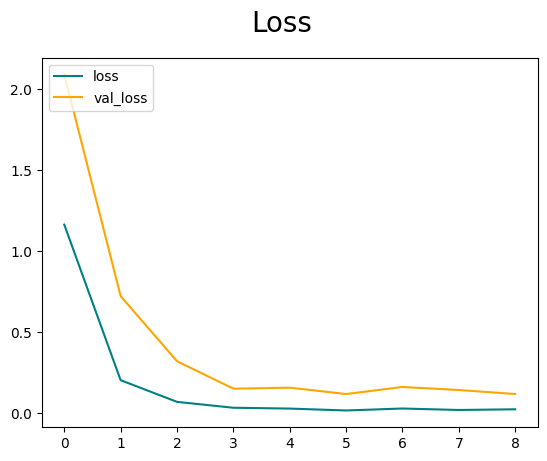

In [39]:
fig = plt.figure()

plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

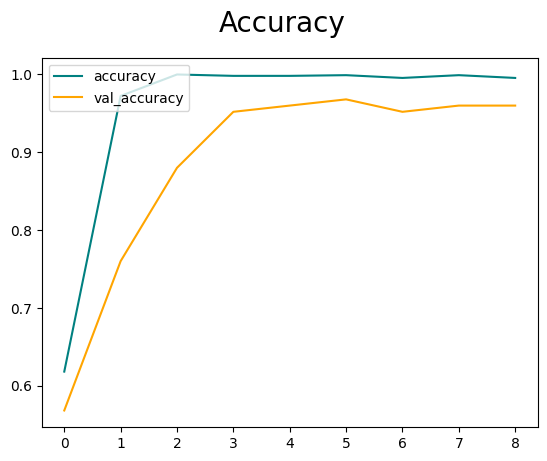

In [40]:
fig = plt.figure()

plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Testing

In [41]:
from sklearn import metrics

In [42]:
y_test = np.argmax(y_test, axis=1)

In [43]:
y_pred = model.predict(X_test)

10/10 [==============================] - 23s 2s/step


In [44]:
y_pred = np.argmax(y_pred, axis=1)

In [45]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        57
           1       0.93      0.98      0.95        42
           2       0.98      0.97      0.98        66
           3       0.93      0.93      0.93        29
           4       0.98      1.00      0.99        42
           5       1.00      0.83      0.91        42
           6       0.83      1.00      0.91        35

    accuracy                           0.95       313
   macro avg       0.95      0.95      0.95       313
weighted avg       0.96      0.95      0.95       313



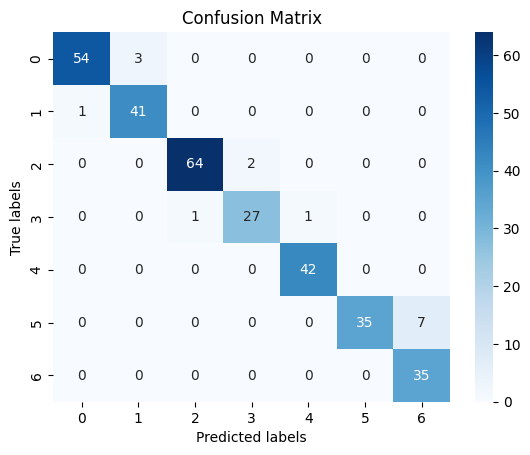

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Saving the model

In [47]:
model.save('can_volume_brand_classification_model')

### Convert our model to TFLite 
#### TFLite is a lighter version of our model which can be deployed in an embedded system such as a raspberry pi

In [48]:
model = tf.keras.models.load_model('can_volume_brand_classification_model')

In [49]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [50]:
tflite_model = converter.convert()

In [51]:
open("can_volume_brand_classification_model_tflite.tflite", "wb").write(tflite_model)

190014744

### Compressing and exporting our model 

In [52]:
!zip -r can_volume_brand_classification_model.zip can_volume_brand_classification_model

  adding: can_volume_brand_classification_model/ (stored 0%)
  adding: can_volume_brand_classification_model/saved_model.pb (deflated 92%)
  adding: can_volume_brand_classification_model/assets/ (stored 0%)
  adding: can_volume_brand_classification_model/keras_metadata.pb (deflated 96%)
  adding: can_volume_brand_classification_model/fingerprint.pb (stored 0%)
  adding: can_volume_brand_classification_model/variables/ (stored 0%)
  adding: can_volume_brand_classification_model/variables/variables.index (deflated 78%)
  adding: can_volume_brand_classification_model/variables/variables.data-00000-of-00001 (deflated 19%)


In [53]:
!cp can_volume_brand_classification_model.zip drive/MyDrive

In [54]:
!zip -r can_volume_brand_classification_model_tflite.zip can_volume_brand_classification_model_tflite.tflite

  adding: can_volume_brand_classification_model_tflite.tflite (deflated 7%)


In [55]:
!cp can_volume_brand_classification_model_tflite.zip drive/MyDrive